The work that follows examines hyperparameter tuning in the context of supervised machine learning in order to identify the most ideal parameters that achieve a compromise between accuracy and fairness metrics and improve the human-orientedness of machine learning models. It is necessary to categorize two categories of persons.  Bank Marketing and adult datasets from the aif360[LFR] library are used in the study. The Support Vector Machine model is utilisutilizeded for the classification, which is based on the features "age" for bank marketing and "sex" for the Adult dataset (SVM).

Installing the aif360[LFR] library, finding the proper location, and importing the dataset are the first steps.

In [ ]:
!pip install 'aif360[LFR]'

In [ ]:
!pip install fairlearn

In [ ]:
pip install scikit-lego

In [4]:
# import all necessary libraries

import numpy as np
import pandas as pd
from aif360.datasets import GermanDataset
from aif360.datasets import BankDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
import pdb
import random
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import *
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklego.metrics import equal_opportunity_score
from aif360.metrics import BinaryLabelDatasetMetric, DatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import OrderedDict

np.random.seed(0)

The function that follows takes a dataset's name as an input, configures privileged and unprivileged classes with values of 1 and 0, respectively, for training, and divides the dataset into training and test sets in a proportion of 70:30. To determine the hyperparameter values for the most accurate model—the model that gives the highest accuracy on the train set—as well as the most fair model, which will have shown equal opportunity for both classes (although accuracy may be lower) and serves as a more generalised model, we first perform all operations on the Bank dataset.

In [5]:
def dataset(dataset):
  privileged = [{'sex': 1}]
  unprivileged = [{'sex': 0}]
  dataset_original = dataset(['sex'])


  train, test = dataset_original.split([0.7], shuffle=True)
  print("training data size", train.features.shape)
  print("dataset feature names", train.feature_names)

  scale_orig = StandardScaler()
  X_train = scale_orig.fit_transform(train.features)
  y_train = train.labels.ravel()

  X_test = scale_orig.transform(test.features) 
  y_test = test.labels.ravel()

  return privileged, unprivileged, train, test, X_train, y_train, X_test, y_test

The following function accepts both the training and test sets as well as the set of hyperparameters we are testing. To identify the combination of the two that produces the most accurate and equitable model for our SVM model, we will alter the regularisation term C and the gamma value. Below is a derivation of a similar function for employing sample weights in hyperparameter tuning.

In [6]:
def tune_hyperparameters(cvalues, gammavalues, X_train, y_train):
  
  folds = StratifiedKFold(n_splits=5)
  accuracy_score = {}
  equality_error = {}
  
  i_val = []
  j_val = []
  accuracy_dict={}
  for i in cvalues:
    for j in gammavalues:
      score = []
      eod = []
      for train_index, test_index in folds.split(X_train, y_train):
        X_trn, X_tst, y_trn, y_tst = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
        mod = SVC(C=i, gamma=j, kernel='rbf')
        mod.fit(X_trn, y_trn)
        score.append(mod.score(X_tst, y_tst))
        predictions = mod.predict(X_tst)
       
        tot_pos = 0
        tot_neg = 0

        for val in range(len(predictions)):
          if y_tst[val]==1:
            tot_pos+=1
          if y_tst[val]==0:
            tot_neg+=1
          else:
            continue

        p = 0
        n = 0
        for val in range(len(predictions)):
          if y_tst[val]==1 and y_tst[val]==predictions[val]:
            p+=1
          if y_tst[val]==0 and y_tst[val]==predictions[val]:
            n+=1
          else:
            continue

        if tot_pos==0:
          equal_opportunity_diff = 0
        elif tot_neg==0:
          equal_opportunity_diff = 0
        else:
          equal_opportunity_diff = abs((p/tot_pos)-(n/tot_neg))
        
        eod.append(equal_opportunity_diff)

      i_val.append(i)
      j_val.append(j)
      accuracy_score["C="+str(i)+"_gamma="+str(j)] = np.average(score)
     
      
      
      equality_error["C="+str(i)+"_gamma="+str(j)] = np.average(eod)
      
      

  print("Maximum accuracy value on training set: ", round((max(accuracy_score.values())*100),2), "%")
  #print("Hyperparameter values to achieve maximum accuracy: ", list(accuracy_score.keys())[list(accuracy_score.values()).index(max(accuracy_score.values()))])
  print("Hyperparameter values to achieve maximum accuracy: ", [k for k,v in accuracy_score.items() if v == max(accuracy_score.values())])  
  print("Minimum error value: ", round(min(equality_error.values(), key=abs),4))
  print("Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes): ", [k for k,v in equality_error.items() if v == min(equality_error.values(), key=abs)])

  return i_val, j_val, accuracy_score, equality_error

In [7]:
def tune_weighted_hyperparameters(c_val, gamma_val, X_train, y_train, weights):
  
  folds = StratifiedKFold(n_splits=5)
  accuracy_score = {}
  equality_error = {}
  i_val = []
  j_val = []

  for i in c_val:
    for j in gamma_val:
      score = []
      eod = []
      for train_index, test_index in folds.split(X_train, y_train):
        X_trn, X_tst, y_trn, y_tst = X_train[train_index], X_train[test_index], y_train[train_index], y_train[test_index]
        mod = SVC(C=i, gamma=j, kernel='rbf')
        mod.fit(X_trn, y_trn, sample_weight=weights[train_index])     #sample weights
        score.append(mod.score(X_tst, y_tst))
        predictions = mod.predict(X_tst)

        tot_pos = 0
        tot_neg = 0

        for val in range(len(predictions)):
          if y_tst[val]==1:
            tot_pos+=1
          if y_tst[val]==0:
            tot_neg+=1
          else:
            continue

        p = 0
        n = 0
        for val in range(len(predictions)):
          if y_tst[val]==1 and y_tst[val]==predictions[val]:
            p+=1
          if y_tst[val]==0 and y_tst[val]==predictions[val]:
            n+=1
          else:
            continue

        if tot_pos==0:
          equal_opportunity_diff = 0
        elif tot_neg==0:
          equal_opportunity_diff = 0
        else:
          equal_opportunity_diff = abs((p/tot_pos)-(n/tot_neg))
        
        eod.append(equal_opportunity_diff)
      
      i_val.append(i)
      j_val.append(j)

      accuracy_score["C="+str(i)+"_gamma="+str(j)] = np.average(score)
      
      equality_error["C="+str(i)+"_gamma="+str(j)] = np.average(eod)


  print("Maximum accuracy value on training set: ", round((max(accuracy_score.values())*100),2), "%")
  #print("Hyperparameter values to achieve maximum accuracy: ", list(accuracy_score.keys())[list(accuracy_score.values()).index(max(accuracy_score.values()))])
  print("Hyperparameter values to achieve maximum accuracy: ", [k for k,v in accuracy_score.items() if v == max(accuracy_score.values())])
  print("Minimum error value: ", round(min(equality_error.values(), key=abs),4))
  print("Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes): ", [k for k,v in equality_error.items() if v == min(equality_error.values(), key=abs)])

  return i_val, j_val, accuracy_score, equality_error

The following two blocks of codes are functions to run specific combinations of C and gamma as input by user to print the accuracy and fairness metrics of an SVM model. Similar to before, there are two functions for the same, one considers sample weights and the other does not.

In [8]:
def simple_model(svm, X_train, X_test, y_train, y_test, test, unprivileged, privileged):

  folds = StratifiedKFold(n_splits=5)
  for train_ind, test_ind in folds.split(X_train, y_train):
    X_trn, X_tst, y_trn, y_tst = X_train[train_ind], X_train[test_ind], y_train[train_ind], y_train[test_ind]
    mod_try = svm
    mod_try.fit(X_trn, y_trn)

  predict_test = mod_try.predict(X_test)
  test_pred_try = test.copy()
  test_pred_try.labels = predict_test
  print("Accuracy on test: ", round((mod_try.score(X_test, y_test)*100),2), "%")

  f_metric = ClassificationMetric(test, test_pred_try, unprivileged_groups=unprivileged, privileged_groups=privileged)

  print("Equal opportunity difference: ", round(f_metric.equal_opportunity_difference(),3))
  print("Disparate Impact: ", round(f_metric.disparate_impact(),3))

  print(confusion_matrix(test.labels, test_pred_try.labels))



In [9]:
def reweighted_model(svm, X_train, X_test, y_train, y_test, test, unprivileged, privileged, weights):

  folds = StratifiedKFold(n_splits=5)
  for train_ind, test_ind in folds.split(X_train, y_train):
    X_trn, X_tst, y_trn, y_tst = X_train[train_ind], X_train[test_ind], y_train[train_ind], y_train[test_ind]
    mod_try = svm
    mod_try.fit(X_trn, y_trn, sample_weight=weights[train_ind])     #sample weights

  predict_test = mod_try.predict(X_test)
  test_pred_try = test.copy()
  test_pred_try.labels = predict_test
  print("Accuracy on test: ", round((mod_try.score(X_test, y_test)*100),2), "%")

  f_metric = ClassificationMetric(test, test_pred_try, unprivileged_groups=unprivileged, privileged_groups=privileged)
  print("Equal opportunity difference: ", round(f_metric.equal_opportunity_difference(),3))
  print("Disparate Impact: ", round(f_metric.disparate_impact(),3))

  print(confusion_matrix(test.labels, test_pred_try.labels))



# TASK 1 

Our analysis begins below. First we import the Bank Marketing dataset dataset  and assigning the values returned for the next steps (i.e., train and test sets). We get to see a bit about the data and the number and types of features in the dataset. To see the effect of changing the parameter values, we will first vary only reglarization term C keeping gamma constant and then plot the respective accuracy and fairness quotients against the C values

In [10]:
cd '/usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank'

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank


In [11]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

--2022-08-14 09:59:31--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 434.15K  --.-KB/s    in 0.1s    

2022-08-14 09:59:32 (3.04 MB/s) - ‘bank-additional.zip’ saved [444572/444572]



As !weget method was not working corretly for unziping the files, we will use the !curl command

In [127]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  434k  100  434k    0     0  1307k      0 --:--:-- --:--:-- --:--:-- 1307k


In [130]:
!unzip -o bank-additional.zip -d /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank 

Archive:  bank-additional.zip
   creating: /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/bank-additional/
  inflating: /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/bank-additional/.DS_Store  
   creating: /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/__MACOSX/
   creating: /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/__MACOSX/bank-additional/
  inflating: /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/__MACOSX/bank-additional/._.DS_Store  
  inflating: /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/bank-additional/.Rhistory  
  inflating: /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/bank-additional/bank-additional-full.csv  
  inflating: /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/bank-additional/bank-additional-names.txt  
  inflating: /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/bank-additional/bank-additional.csv  
  inflating: /usr/local/lib/python3.7/di

In [131]:
!mv /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/bank-additional/bank-additional-full.csv /usr/local/lib/python3.7/dist-packages/aif360/data/raw/bank/bank-additional-full.csv

In [132]:
from sklearn.preprocessing import StandardScaler
dataset_original = BankDataset(protected_attribute_names=['age'],                                                                                                                                                 # consider in this evaluation
                             privileged_classes=[lambda x: x >= 25],      # age >=25 is privileged group and age< 25 is unprivilledged 
                             features_to_drop=['contact', 'marital']) 

train_bk, test_bk = dataset_original.split([0.7], shuffle=True)
scale_orig = StandardScaler()
X_train_bk = scale_orig.fit_transform(train_bk.features)
y_train_bk = train_bk.labels.ravel()

X_test_bk = scale_orig.transform(test_bk.features) 
y_test_bk = test_bk.labels.ravel()



privileged_bank = [{'age': 1}]
unprivileged_bank = [{'age': 0}]

In [133]:
print("Preprocessed dataset shape : ",dataset_original.features.shape)
print("Shape of training dataset: ", train_bk.features.shape)
print("Shape of testing dataset: ", test_bk.features.shape)


Preprocessed dataset shape :  (30547, 52)
Shape of training dataset:  (21382, 52)
Shape of testing dataset:  (9165, 52)


Maximum accuracy value on training set:  87.78 %
Hyperparameter values to achieve maximum accuracy:  ['C=15.797894736842105_gamma=0.1']
Minimum error value:  0.6201
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=47.373684210526314_gamma=0.1']


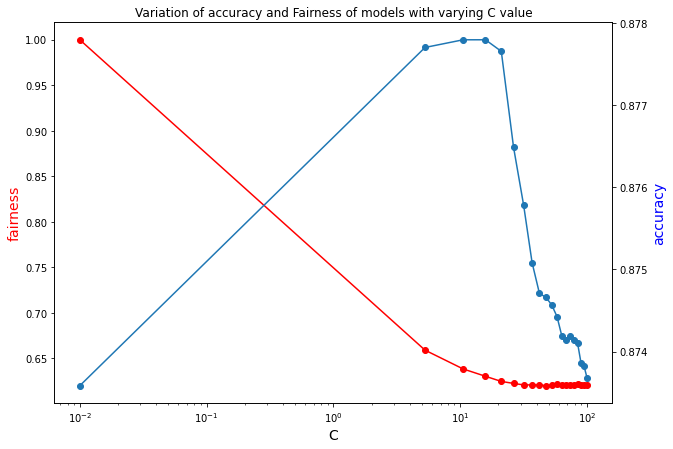

In [18]:
c_variable = list(np.linspace(0.01, 100, 20))
gamma_const = [0.1]


x_for_c, const_gamma, y_accuracy_varc, y_error_varc = tune_hyperparameters(c_variable, gamma_const, X_train_bk, y_train_bk)

fig,ax = plt.subplots(figsize=(10,7))
ax.plot(x_for_c, list(y_error_varc.values()), marker = 'o', color = 'r')
ax.set_xlabel("C",fontsize=14)
ax.set_ylabel("fairness",color="red",fontsize=14)
ax.set_xscale('log')

# twin object for two different y-axis
ax2=ax.twinx()
ax2.plot(x_for_c, list(y_accuracy_varc.values()), marker = 'o')
ax2.set_ylabel("accuracy",color="blue",fontsize=14)
ax2.set_xscale('log')
plt.title("Variation of accuracy and Fairness of models with varying C value")



Text(0.5, 1.0, 'Variation of accuracy and Fairness of models with varying C value')

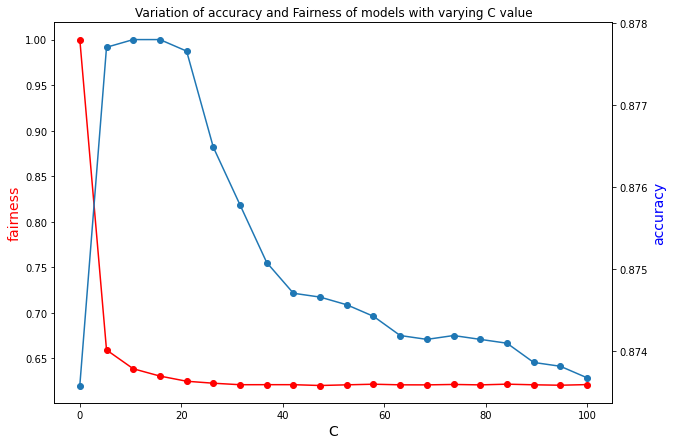

In [23]:
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(x_for_c, list(y_error_varc.values()), marker = 'o', color = 'r')
ax.set_xlabel("C",fontsize=14)
ax.set_ylabel("fairness",color="red",fontsize=14)


# twin object for two different y-axis
ax2=ax.twinx()
ax2.plot(x_for_c, list(y_accuracy_varc.values()), marker = 'o')
ax2.set_ylabel("accuracy",color="blue",fontsize=14)
plt.title("Variation of accuracy and Fairness of models with varying C value")



Maximum accuracy value on training set:  89.89 %
Hyperparameter values to achieve maximum accuracy:  ['C=1_gamma=0.01']
Minimum error value:  0.6008
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=1_gamma=0.01']


Text(0.5, 1.0, 'Variation of accuracy and Fairness of models with varying gamma value')

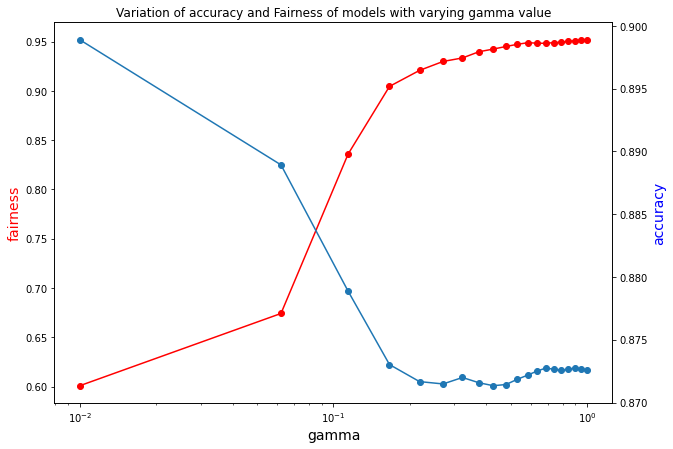

In [20]:

c_const = [1]
gamma_variable = list(np.linspace(0.01, 1, 20))

cvalconst, x_for_g, y_accuracy_varg, y_error_varg = tune_hyperparameters(c_const, gamma_variable, X_train_bk, y_train_bk)
from matplotlib.pyplot import figure
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(x_for_g, list(y_error_varg.values()), marker = 'o', color = 'r')
ax.set_xlabel("gamma",fontsize=14)
ax.set_ylabel("fairness",color="red",fontsize=14)
ax.set_xscale('log')

# twin object for two different y-axis
ax2=ax.twinx()
ax2.plot(x_for_g, list(y_accuracy_varg.values()), marker = 'o')
ax2.set_ylabel("accuracy",color="blue",fontsize=14)
ax2.set_xscale('log')
plt.title("Variation of accuracy and Fairness of models with varying gamma value")


Text(0.5, 1.0, 'Variation of accuracy and Fairness of models with varying gamma value')

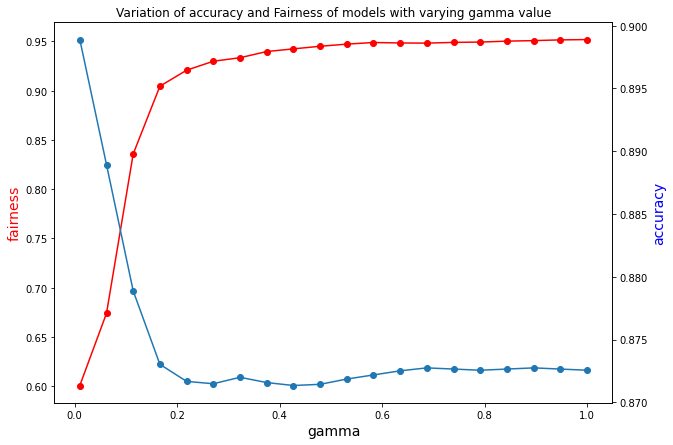

In [48]:
from matplotlib.pyplot import figure
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(x_for_g, list(y_error_varg.values()), marker = 'o', color = 'r')
ax.set_xlabel("gamma",fontsize=14)
ax.set_ylabel("fairness",color="red",fontsize=14)


# twin object for two different y-axis
ax2=ax.twinx()
ax2.plot(x_for_g, list(y_accuracy_varg.values()), marker = 'o')
ax2.set_ylabel("accuracy",color="blue",fontsize=14)

plt.title("Variation of accuracy and Fairness of models with varying gamma value")


Text(0.5, 1.0, 'Variation of accuracy and Fairness of models with varying gamma value')

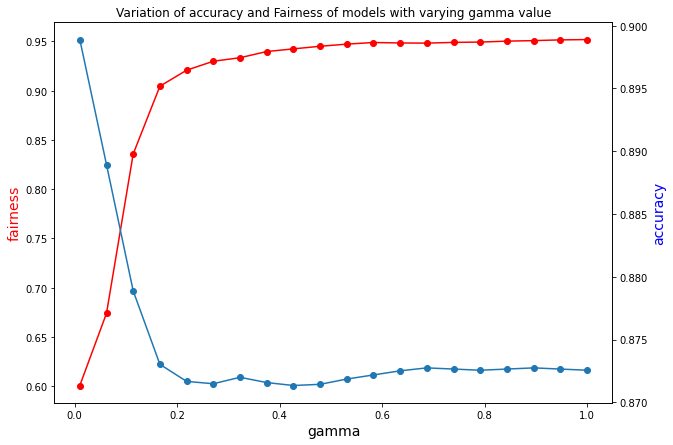

In [21]:
from matplotlib.pyplot import figure
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(x_for_g, list(y_error_varg.values()), marker = 'o', color = 'r')
ax.set_xlabel("gamma",fontsize=14)
ax.set_ylabel("fairness",color="red",fontsize=14)


# twin object for two different y-axis
ax2=ax.twinx()
ax2.plot(x_for_g, list(y_accuracy_varg.values()), marker = 'o')
ax2.set_ylabel("accuracy",color="blue",fontsize=14)
plt.title("Variation of accuracy and Fairness of models with varying gamma value")


In [33]:
c_variable = [0.01,0.1, 1, 10]
gamma_variable = [0.001, 0.01, 0.1, 1]

a, b, c, d = tune_hyperparameters(c_variable, gamma_variable, X_train_bk, y_train_bk)


Maximum accuracy value on training set:  89.89 %
Hyperparameter values to achieve maximum accuracy:  ['C=1_gamma=0.01']
Minimum error value:  0.5148
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=10_gamma=0.01']


In [34]:
df_bank = pd.DataFrame(c.items(), columns=['Hyperparameters', 'Accuracy'])

df_bank["Equality difference"] = df_bank["Hyperparameters"].map(d)
df_bank.sort_values(by=["Accuracy"], ascending=False)

,Hyperparameters,Accuracy,Equality difference
9,C=1_gamma=0.01,0.898887,0.600821
13,C=10_gamma=0.01,0.898513,0.514836
12,C=10_gamma=0.001,0.897203,0.635745
8,C=1_gamma=0.001,0.889533,0.729866
4,C=0.1_gamma=0.001,0.887148,0.777531
5,C=0.1_gamma=0.01,0.887101,0.771549
10,C=1_gamma=0.1,0.881536,0.801163
14,C=10_gamma=0.1,0.877561,0.640768
0,C=0.01_gamma=0.001,0.873585,1.000000
1,C=0.01_gamma=0.01,0.873585,1.000000


In [35]:

df_bank["Absolute difference"]=abs(df_bank["Equality difference"])
df_bank.sort_values(by=["Absolute difference"])

,Hyperparameters,Accuracy,Equality difference,Absolute difference
13,C=10_gamma=0.01,0.898513,0.514836,0.514836
9,C=1_gamma=0.01,0.898887,0.600821,0.600821
12,C=10_gamma=0.001,0.897203,0.635745,0.635745
14,C=10_gamma=0.1,0.877561,0.640768,0.640768
8,C=1_gamma=0.001,0.889533,0.729866,0.729866
5,C=0.1_gamma=0.01,0.887101,0.771549,0.771549
4,C=0.1_gamma=0.001,0.887148,0.777531,0.777531
10,C=1_gamma=0.1,0.881536,0.801163,0.801163
15,C=10_gamma=1,0.865962,0.887516,0.887516
11,C=1_gamma=1,0.872556,0.951809,0.951809


WIn the dataframe, we add a new column called Absolute difference, which represents the absolute value of EOD. It is useful to know precisely how distant a point is from the 0 point. The SVC(C=10, gamma=0.01) model has the highest accuracy on the training set, according to our output, with a score of 89.95%, however it also has a high EOD 0.5148. The most ideal parameters must be selected, thus proper considerations must be made.

Our next job is to apply the respective models with parameters obtained above on the test sets to see how they fare.

Most Accurate model with c= 10 and gamma = 0.01

In [36]:
simple_model(SVC(C=1, gamma=0.01, kernel='rbf'), X_train_bk, X_test_bk, y_train_bk, y_test_bk, test_bk, unprivileged_bank, privileged_bank)

Accuracy on test:  89.49 %
Equal opportunity difference:  0.045
Disparate Impact:  1.7
[[7773  227]
 [ 736  429]]


Most Fair Model

In [37]:
simple_model(SVC(C=10, gamma=0.01, kernel='rbf'), X_train_bk, X_test_bk, y_train_bk, y_test_bk, test_bk, unprivileged_bank, privileged_bank)

Accuracy on test:  89.13 %
Equal opportunity difference:  -0.009
Disparate Impact:  1.712
[[7660  340]
 [ 656  509]]


Higher values of C and gamma, as expected, contributed the most to accuracy. It would make sense because the model seeks to reduce misclassifications in order to increase accuracy and a high value of C indicates heavier penalties on points categorised improperly. A greater gamma value, on the other hand, suggests class similarity within a narrower space. In the fair model, when gamma is low, similarities in the samples spanning greater distances are taken into account, which could lead to inaccurate classification (with low penalties as well if C is low as in fair model). This demonstrates that a fairer model is less accurate but more generalizable.

We perform all the above task again on a new dataset called Adult where again, classification is based on a protected feature "sex" and the model is still SVM.

In [38]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

In [40]:
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
privileged_adult, unprivileged_adult, train_ad, test_ad, X_train_ad, y_train_ad, X_test_ad, y_test_ad = dataset(load_preproc_data_adult)

training data size (34189, 18)
dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [41]:
c_variable_ad = list(np.linspace(0.01, 10, 20))
gamma_const_ad = [0.1]

cval_adult, gval_adult, adult_accuracy, adult_fair = tune_hyperparameters(c_variable_ad, gamma_const_ad, X_train_ad, y_train_ad)

Maximum accuracy value on training set:  80.3 %
Hyperparameter values to achieve maximum accuracy:  ['C=4.2163157894736845_gamma=0.1', 'C=4.742105263157895_gamma=0.1', 'C=5.267894736842106_gamma=0.1', 'C=5.793684210526316_gamma=0.1', 'C=6.319473684210527_gamma=0.1', 'C=6.845263157894737_gamma=0.1', 'C=7.371052631578948_gamma=0.1', 'C=7.8968421052631586_gamma=0.1', 'C=8.42263157894737_gamma=0.1', 'C=8.948421052631579_gamma=0.1', 'C=9.47421052631579_gamma=0.1', 'C=10.0_gamma=0.1']
Minimum error value:  0.5235
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=4.2163157894736845_gamma=0.1', 'C=4.742105263157895_gamma=0.1', 'C=5.267894736842106_gamma=0.1', 'C=5.793684210526316_gamma=0.1', 'C=6.319473684210527_gamma=0.1', 'C=6.845263157894737_gamma=0.1', 'C=7.371052631578948_gamma=0.1', 'C=7.8968421052631586_gamma=0.1', 'C=8.42263157894737_gamma=0.1', 'C=8.948421052631579_gamma=0.1', 'C=9.47421052631579_gamma=0.1', 'C=10.0_gamma=0.1']


Text(0.5, 1.0, 'Variation of accuracy and Fairness of models with varying C value on Adult dataset')

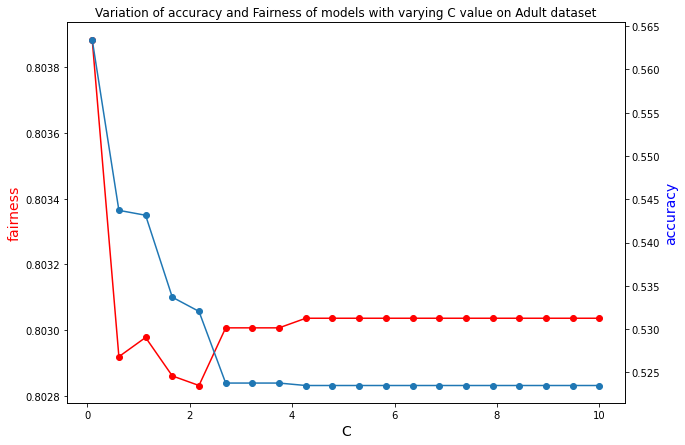

In [47]:
from matplotlib.pyplot import figure
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(cval_adult, list(adult_accuracy.values()), marker = 'o', color = 'r')
ax.set_xlabel("C",fontsize=14)
ax.set_ylabel("fairness",color="red",fontsize=14)



# twin object for two different y-axis
ax2=ax.twinx()
ax2.plot(cval_adult, list(adult_fair.values()), marker = 'o')
ax2.set_ylabel("accuracy",color="blue",fontsize=14)

plt.title("Variation of accuracy and Fairness of models with varying C value on Adult dataset")


In [43]:
c_variable_ad1 = list(np.linspace(0.1, 10, 20))
gamma_const_ad1 = [0.1]

cval_adult, gval_adult, adult_accuracy, adult_fair = tune_hyperparameters(c_variable_ad1, gamma_const_ad1, X_train_ad, y_train_ad)

Maximum accuracy value on training set:  80.39 %
Hyperparameter values to achieve maximum accuracy:  ['C=0.1_gamma=0.1']
Minimum error value:  0.5235
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=4.268421052631579_gamma=0.1', 'C=4.7894736842105265_gamma=0.1', 'C=5.310526315789474_gamma=0.1', 'C=5.831578947368421_gamma=0.1', 'C=6.352631578947369_gamma=0.1', 'C=6.873684210526316_gamma=0.1', 'C=7.394736842105264_gamma=0.1', 'C=7.915789473684211_gamma=0.1', 'C=8.436842105263159_gamma=0.1', 'C=8.957894736842105_gamma=0.1', 'C=9.478947368421053_gamma=0.1', 'C=10.0_gamma=0.1']


Text(0.5, 1.0, 'Variation of accuracy and Fairness of models with varying C value on Adult dataset')

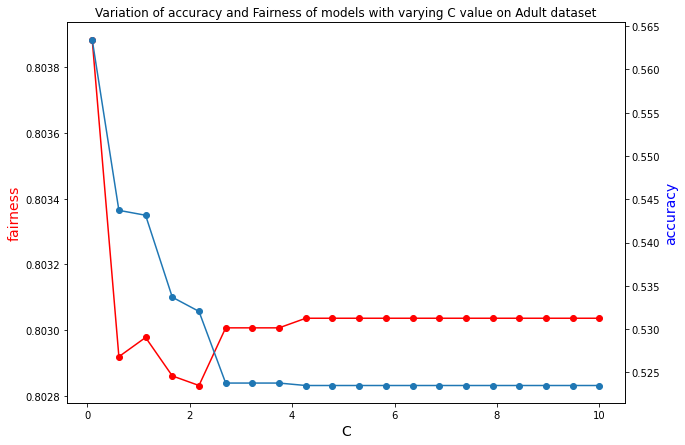

In [45]:
from matplotlib.pyplot import figure
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(cval_adult, list(adult_accuracy.values()), marker = 'o', color = 'r')
ax.set_xlabel("C",fontsize=14)
ax.set_ylabel("fairness",color="red",fontsize=14)



# twin object for two different y-axis
ax2=ax.twinx()
ax2.plot(cval_adult, list(adult_fair.values()), marker = 'o')
ax2.set_ylabel("accuracy",color="blue",fontsize=14)

plt.title("Variation of accuracy and Fairness of models with varying C value on Adult dataset")


Maximum accuracy value on training set:  80.31 %
Hyperparameter values to achieve maximum accuracy:  ['C=10_gamma=0.01']
Minimum error value:  0.5221
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=10_gamma=0.06210526315789474']


Text(0.5, 1.0, 'Variation of accuracy and Fairness of models with varying Gamma value on Adult dataset')

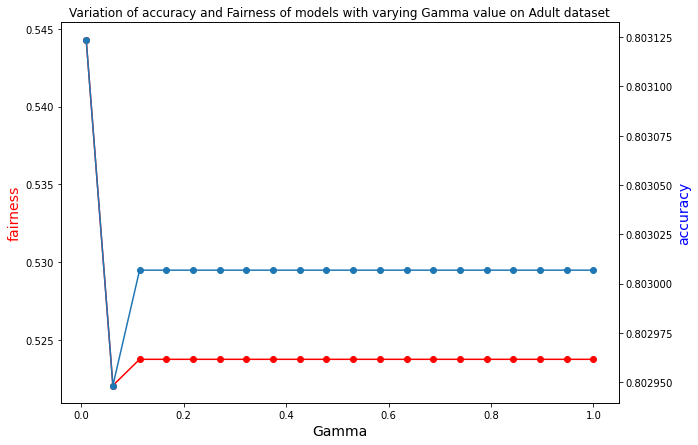

In [50]:
c_val_a = [10]
g_val_a = list(np.linspace(0.01, 1, 20))

cvalsa1, gevala1, geacca1, gefaira1 = tune_hyperparameters(c_val_a, g_val_a, X_train_ad, y_train_ad)

from matplotlib.pyplot import figure
fig,ax = plt.subplots(figsize=(10,7))
ax.plot(gevala1, list(gefaira1.values()), marker = 'o', color = 'r')
ax.set_xlabel("Gamma",fontsize=14)
ax.set_ylabel("fairness",color="red",fontsize=14)


# twin object for two different y-axis
ax2=ax.twinx()
ax2.plot(gevala1, list(geacca1.values()), marker = 'o')
ax2.set_ylabel("accuracy",color="blue",fontsize=14)
plt.title("Variation of accuracy and Fairness of models with varying Gamma value on Adult dataset")


In [51]:
Adult_C = [0.1, 1, 10]
Adult_g = [0.001, 0.01, 0.1, 1]

ac, ag, accu, afair = tune_hyperparameters(Adult_C, Adult_g, X_train_ad, y_train_ad)

Maximum accuracy value on training set:  80.39 %
Hyperparameter values to achieve maximum accuracy:  ['C=0.1_gamma=0.1']
Minimum error value:  0.4188
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=1_gamma=0.001']


In [52]:
df_adult = pd.DataFrame(accu.items(), columns=['Hyperparameters', 'Accuracy'])

df_adult["Equality difference"] = df_adult["Hyperparameters"].map(afair)
df_adult["Absolute difference"]=abs(df_adult["Equality difference"])

df_adult.sort_values(by=["Accuracy"], ascending=False)


,Hyperparameters,Accuracy,Equality difference,Absolute difference
2,C=0.1_gamma=0.1,0.803884,0.563458,0.563458
3,C=0.1_gamma=1,0.803212,0.552615,0.552615
9,C=10_gamma=0.01,0.803124,0.544307,0.544307
10,C=10_gamma=0.1,0.803036,0.523470,0.523470
7,C=1_gamma=1,0.803007,0.523753,0.523753
11,C=10_gamma=1,0.803007,0.523753,0.523753
6,C=1_gamma=0.1,0.802978,0.543151,0.543151
5,C=1_gamma=0.01,0.802978,0.542990,0.542990
1,C=0.1_gamma=0.01,0.790371,0.443852,0.443852
8,C=10_gamma=0.001,0.788938,0.430723,0.430723


In [53]:
simple_model(SVC(C=0.1, gamma=0.1, kernel='rbf'),  X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult)

Accuracy on test:  80.38 %
Equal opportunity difference:  -0.449
Disparate Impact:  0.0
[[10448   703]
 [ 2172  1330]]


In [54]:
simple_model(SVC(C=1, gamma=0.001, kernel='rbf'),  X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult)

Accuracy on test:  78.59 %
Equal opportunity difference:  -0.022
Disparate Impact:  0.689
[[9867 1284]
 [1853 1649]]


# Task 2: Reweighing

In the following section, we employ a technique called reweighing to lower sample variation and enhance model performance. Each input feature in the training phase of this method receives a set of weights based on how much it contributes to the outcome. The model's fairness measures are enhanced by using this technique. After training, we get new parameter combinations (C and gamma) for the most accurate and fair SVM models on the Bank and Adult dataset, respectively.


First we will carry out reweighing on Bank dataset

In [55]:
RW_adult = Reweighing(unprivileged_groups=unprivileged_adult, privileged_groups=privileged_adult)
RW_bank = Reweighing(unprivileged_groups=unprivileged_bank, privileged_groups=privileged_bank)

train_ad = RW_adult.fit_transform(train_ad)
train = RW_bank.fit_transform(train_bk)

In [56]:
c_variable_rw = [0.01, 0.1, 1, 10]
gamma_var_rw = [0.001, 0.01, 0.1, 1]



rwa, rwb, rwc, rwd = tune_weighted_hyperparameters(c_variable_rw, gamma_var_rw, X_train_bk, y_train_bk, train.instance_weights)

Maximum accuracy value on training set:  89.89 %
Hyperparameter values to achieve maximum accuracy:  ['C=1_gamma=0.01']
Minimum error value:  0.5126
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=10_gamma=0.01']


In [57]:
df_bank_rw = pd.DataFrame(rwc.items(), columns=['Hyperparameters', 'Accuracy'])

df_bank_rw["Equality difference"] = df_bank_rw["Hyperparameters"].map(rwd)
df_bank_rw["Absolute difference"]=abs(df_bank_rw["Equality difference"])
df_bank_rw.sort_values(by=["Absolute difference"])


,Hyperparameters,Accuracy,Equality difference,Absolute difference
13,C=10_gamma=0.01,0.898747,0.512563,0.512563
9,C=1_gamma=0.01,0.898934,0.599175,0.599175
12,C=10_gamma=0.001,0.898092,0.631680,0.631680
14,C=10_gamma=0.1,0.877561,0.637381,0.637381
8,C=1_gamma=0.001,0.889533,0.729019,0.729019
5,C=0.1_gamma=0.01,0.886914,0.775146,0.775146
4,C=0.1_gamma=0.001,0.887008,0.778641,0.778641
10,C=1_gamma=0.1,0.881302,0.801319,0.801319
15,C=10_gamma=1,0.865962,0.886668,0.886668
11,C=1_gamma=1,0.872510,0.952603,0.952603


In [58]:
reweighted_model(SVC(C=1, gamma=0.01, kernel='rbf'), X_train_bk, X_test_bk, y_train_bk, y_test_bk, test_bk, unprivileged_bank, privileged_bank, train.instance_weights)

Accuracy on test:  89.43 %
Equal opportunity difference:  -0.209
Disparate Impact:  0.611
[[7777  223]
 [ 746  419]]


In [59]:
reweighted_model(SVC(C=10, gamma=0.01, kernel='rbf'), X_train_bk, X_test_bk, y_train_bk, y_test_bk, test_bk, unprivileged_bank, privileged_bank, train.instance_weights)

Accuracy on test:  89.21 %
Equal opportunity difference:  -0.087
Disparate Impact:  1.296
[[7663  337]
 [ 652  513]]


In [60]:
reweighted_model(SVC(C=100, gamma=0.001, kernel='rbf'), X_train_bk, X_test_bk, y_train_bk, y_test_bk, test_bk, unprivileged_bank, privileged_bank, train.instance_weights)

Accuracy on test:  89.6 %
Equal opportunity difference:  -0.144
Disparate Impact:  0.941
[[7720  280]
 [ 673  492]]


Now we will perfrom the above evaluation on Adult dataset

In [61]:
Adult_C_variable = [0.1, 1, 10,100]
Adult_gamma_var = [0.001, 0.01, 0.1, 1]

ac, ag, accuracy, fairness = tune_weighted_hyperparameters(Adult_C_variable, Adult_gamma_var, X_train_ad, y_train_ad, train_ad.instance_weights)

Maximum accuracy value on training set:  79.06 %
Hyperparameter values to achieve maximum accuracy:  ['C=0.1_gamma=1']
Minimum error value:  0.4188
Hyperparameter values to achieve maximum fairness (i.e. Equal opportunity for both classes):  ['C=1_gamma=0.001']


In [62]:
df_adult_rw = pd.DataFrame(accuracy.items(), columns=['Hyperparameters', 'Accuracy'])

df_adult_rw["Equality difference"] = df_adult_rw["Hyperparameters"].map(fairness)
df_adult_rw["Absolute difference"]=abs(df_adult_rw["Equality difference"])
df_adult_rw.sort_values(by=["Absolute difference"])


,Hyperparameters,Accuracy,Equality difference,Absolute difference
4,C=1_gamma=0.001,0.786920,0.418753,0.418753
8,C=10_gamma=0.001,0.786949,0.418792,0.418792
1,C=0.1_gamma=0.01,0.787914,0.430020,0.430020
12,C=100_gamma=0.001,0.787973,0.430097,0.430097
5,C=1_gamma=0.01,0.787973,0.430739,0.430739
10,C=10_gamma=0.1,0.788558,0.458655,0.458655
11,C=10_gamma=1,0.788558,0.458655,0.458655
14,C=100_gamma=0.1,0.788558,0.458655,0.458655
15,C=100_gamma=1,0.788558,0.458655,0.458655
13,C=100_gamma=0.01,0.790225,0.458919,0.458919


In [63]:
reweighted_model(SVC(C=0.01, gamma=1, kernel='rbf'), X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult, train_ad.instance_weights)

Accuracy on test:  78.68 %
Equal opportunity difference:  -0.118
Disparate Impact:  0.454
[[10664   487]
 [ 2637   865]]


In [64]:
reweighted_model(SVC(C=1, gamma=0.001, kernel='rbf'), X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult, train_ad.instance_weights)

Accuracy on test:  78.59 %
Equal opportunity difference:  -0.022
Disparate Impact:  0.689
[[9867 1284]
 [1853 1649]]


As a result, we can observe that the equal opportunity difference decreased for both the most accurate model and the overall model. The variance was reduced when the samples were weighted during training. The accuracy value decreased slightly but remains around the same as previously.

# **TASK 3 -  Most Optimal Model**

Here is a simple rating system for the models that were previously developed. We must comprehend a model's requirements in order to determine the parameters that will work best for it. Whether it is tilted more in favour of fairness or accuracy.

The combination with the lowest accuracy is given a score of 1, and the one with the highest accuracy is given a score of 10, according to the tables created after hyperparameter tuning and training the models. The remaining models are given a score between 1 and 10 depending on their accuracy, with the range between the highest and lowest accuracy divided into 10 equal parts. The fairness metric use the same concept, but the highest score is given to the least TPR difference. At the end we just add the accuracy and fairness scores to have a rough idea about where each model stands.

In [65]:
def optimal_selection(testdf):

  testdf["Accuracy"] = round(testdf["Accuracy"]*100, 2)
  testdf["Equality difference"] = round(testdf["Equality difference"], 3)
  testdf["Absolute difference"] = round(testdf["Absolute difference"], 3)

  testdf["Accuracy score"] = testdf["Accuracy"]*0
  testdf["Fairness score"] = testdf["Accuracy"]*0
  testdf


  min = testdf["Accuracy"].min()
  max = testdf["Accuracy"].max()
  step = (max-min)/10

  for av in range(len(testdf["Accuracy"])):
    
    if testdf["Accuracy"][av]>=min and testdf["Accuracy"][av]<min+step:
      testdf["Accuracy score"][av]=1
    elif testdf["Accuracy"][av]>=min+step and testdf["Accuracy"][av]<min+(step*2):
      testdf["Accuracy score"][av]=2
    elif testdf["Accuracy"][av]>=min+(step*2) and testdf["Accuracy"][av]<min+(step*3):
      testdf["Accuracy score"][av]=3
    elif testdf["Accuracy"][av]>=min+(step*3) and testdf["Accuracy"][av]<min+(step*4):
      testdf["Accuracy score"][av]=4
    elif testdf["Accuracy"][av]>=min+(step*4) and testdf["Accuracy"][av]<min+(step*5):
      testdf["Accuracy score"][av]=5
    elif testdf["Accuracy"][av]>=min+(step*5) and testdf["Accuracy"][av]<min+(step*6):
      testdf["Accuracy score"][av]=6
    elif testdf["Accuracy"][av]>=min+(step*6) and testdf["Accuracy"][av]<min+(step*7):
      testdf["Accuracy score"][av]=7
    elif testdf["Accuracy"][av]>=min+(step*7) and testdf["Accuracy"][av]<min+(step*8):
      testdf["Accuracy score"][av]=8
    elif testdf["Accuracy"][av]>=min+(step*8) and testdf["Accuracy"][av]<min+(step*9):
      testdf["Accuracy score"][av]=9
    elif testdf["Accuracy"][av]>=min+(step*9):
      testdf["Accuracy score"][av]=10



  low = testdf["Absolute difference"].min()
  high = testdf["Absolute difference"].max()
  gap = (high-low)/10


  for fv in range(len(testdf["Absolute difference"])):
  
    if testdf["Absolute difference"][fv]>=low and testdf["Absolute difference"][fv]<low+gap:
      testdf["Fairness score"][fv]=10
    elif testdf["Absolute difference"][fv]>=low+gap and testdf["Absolute difference"][fv]<low+(gap*2):
      testdf["Fairness score"][fv]=9
    elif testdf["Absolute difference"][fv]>=low+(gap*2) and testdf["Absolute difference"][fv]<low+(gap*3):
      testdf["Fairness score"][fv]=8
    elif testdf["Absolute difference"][fv]>=low+(gap*3) and testdf["Absolute difference"][fv]<low+(gap*4):
      testdf["Fairness score"][fv]=7
    elif testdf["Absolute difference"][fv]>=low+(gap*4) and testdf["Absolute difference"][fv]<low+(gap*5):
      testdf["Fairness score"][fv]=6
    elif testdf["Absolute difference"][fv]>=low+(gap*5) and testdf["Absolute difference"][fv]<low+(gap*6):
      testdf["Fairness score"][fv]=5
    elif testdf["Absolute difference"][fv]>=low+(gap*6) and testdf["Absolute difference"][fv]<low+(gap*7):
      testdf["Fairness score"][fv]=4
    elif testdf["Absolute difference"][fv]>=low+(gap*7) and testdf["Absolute difference"][fv]<low+(gap*8):
      testdf["Fairness score"][fv]=3
    elif testdf["Absolute difference"][fv]>=low+(gap*8) and testdf["Absolute difference"][fv]<low+(gap*9):
      testdf["Fairness score"][fv]=2
    elif testdf["Absolute difference"][fv]>=low+(gap*9):
      testdf["Fairness score"][fv]=1


  testdf["Total_score"] = testdf["Accuracy score"]+testdf["Fairness score"]
  testdf = testdf.sort_values(by=["Total_score"], ascending=False)
    
    
  return testdf

In [ ]:
nw_bank = optimal_selection(df_bank)
rewt_bank = optimal_selection(df_bank_rw)


In [68]:
nw_bank

,Hyperparameters,Accuracy,Equality difference,Absolute difference,Accuracy score,Fairness score,Total_score
13,C=10_gamma=0.01,89.85,0.515,0.515,10.0,10.0,20.0
9,C=1_gamma=0.01,89.89,0.601,0.601,10.0,9.0,19.0
12,C=10_gamma=0.001,89.72,0.636,0.636,10.0,8.0,18.0
8,C=1_gamma=0.001,88.95,0.730,0.730,8.0,6.0,14.0
4,C=0.1_gamma=0.001,88.71,0.778,0.778,7.0,5.0,12.0
5,C=0.1_gamma=0.01,88.71,0.772,0.772,7.0,5.0,12.0
14,C=10_gamma=0.1,87.76,0.641,0.641,4.0,8.0,12.0
10,C=1_gamma=0.1,88.15,0.801,0.801,5.0,5.0,10.0
0,C=0.01_gamma=0.001,87.36,1.000,1.000,3.0,1.0,4.0
1,C=0.01_gamma=0.01,87.36,1.000,1.000,3.0,1.0,4.0


In [69]:
rewt_bank

,Hyperparameters,Accuracy,Equality difference,Absolute difference,Accuracy score,Fairness score,Total_score
13,C=10_gamma=0.01,89.87,0.513,0.513,10.0,10.0,20.0
9,C=1_gamma=0.01,89.89,0.599,0.599,10.0,9.0,19.0
12,C=10_gamma=0.001,89.81,0.632,0.632,10.0,8.0,18.0
8,C=1_gamma=0.001,88.95,0.729,0.729,8.0,6.0,14.0
4,C=0.1_gamma=0.001,88.70,0.779,0.779,7.0,5.0,12.0
5,C=0.1_gamma=0.01,88.69,0.775,0.775,7.0,5.0,12.0
14,C=10_gamma=0.1,87.76,0.637,0.637,4.0,8.0,12.0
10,C=1_gamma=0.1,88.13,0.801,0.801,5.0,5.0,10.0
0,C=0.01_gamma=0.001,87.36,1.000,1.000,3.0,1.0,4.0
1,C=0.01_gamma=0.01,87.36,1.000,1.000,3.0,1.0,4.0


In [70]:
simple_model(SVC(C=10, gamma=0.01, kernel='rbf'), X_train_bk, X_test_bk, y_train_bk, y_test_bk, test_bk, unprivileged_bank, privileged_bank)

Accuracy on test:  89.13 %
Equal opportunity difference:  -0.009
Disparate Impact:  1.712
[[7660  340]
 [ 656  509]]


In [74]:
reweighted_model(SVC(C=10, gamma=0.01, kernel='rbf'), X_train_bk, X_test_bk, y_train_bk, y_test_bk, test_bk, unprivileged_bank, privileged_bank, train_bk.instance_weights)

Accuracy on test:  89.13 %
Equal opportunity difference:  -0.009
Disparate Impact:  1.712
[[7660  340]
 [ 656  509]]


Task 3 on Adult dataset

In [ ]:
optimal_adult = optimal_selection(df_adult)
rewt_optimal_adult = optimal_selection(df_adult_rw)

In [76]:
optimal_adult

,Hyperparameters,Accuracy,Equality difference,Absolute difference,Accuracy score,Fairness score,Total_score
7,C=1_gamma=1,80.30,0.524,0.524,10.0,9.0,19.0
10,C=10_gamma=0.1,80.30,0.523,0.523,10.0,9.0,19.0
11,C=10_gamma=1,80.30,0.524,0.524,10.0,9.0,19.0
2,C=0.1_gamma=0.1,80.39,0.563,0.563,10.0,8.0,18.0
3,C=0.1_gamma=1,80.32,0.553,0.553,10.0,8.0,18.0
5,C=1_gamma=0.01,80.30,0.543,0.543,10.0,8.0,18.0
6,C=1_gamma=0.1,80.30,0.543,0.543,10.0,8.0,18.0
9,C=10_gamma=0.01,80.31,0.544,0.544,10.0,8.0,18.0
1,C=0.1_gamma=0.01,79.04,0.444,0.444,7.0,10.0,17.0
4,C=1_gamma=0.001,78.69,0.419,0.419,7.0,10.0,17.0


In [77]:
rewt_optimal_adult

,Hyperparameters,Accuracy,Equality difference,Absolute difference,Accuracy score,Fairness score,Total_score
1,C=0.1_gamma=0.01,78.79,0.430,0.430,10.0,10.0,20.0
2,C=0.1_gamma=0.1,78.99,0.473,0.473,10.0,10.0,20.0
5,C=1_gamma=0.01,78.80,0.431,0.431,10.0,10.0,20.0
6,C=1_gamma=0.1,78.98,0.462,0.462,10.0,10.0,20.0
7,C=1_gamma=1,78.95,0.461,0.461,10.0,10.0,20.0
9,C=10_gamma=0.01,78.98,0.465,0.465,10.0,10.0,20.0
10,C=10_gamma=0.1,78.86,0.459,0.459,10.0,10.0,20.0
11,C=10_gamma=1,78.86,0.459,0.459,10.0,10.0,20.0
12,C=100_gamma=0.001,78.80,0.430,0.430,10.0,10.0,20.0
13,C=100_gamma=0.01,79.02,0.459,0.459,10.0,10.0,20.0


In [78]:
simple_model(SVC(C=1, gamma=1, kernel='rbf'), X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult)

Accuracy on test:  80.28 %
Equal opportunity difference:  -0.495
Disparate Impact:  0.0
[[10295   856]
 [ 2034  1468]]


In [80]:
reweighted_model(SVC(C=0.1, gamma=0.01, kernel='rbf'), X_train_ad, X_test_ad, y_train_ad, y_test_ad, test_ad, unprivileged_adult, privileged_adult, train_ad.instance_weights)

Accuracy on test:  78.66 %
Equal opportunity difference:  -0.017
Disparate Impact:  0.693
[[9905 1246]
 [1881 1621]]
